# 21M.387 Fundamentals of Music Processing
## Audio Decomposition

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd
from ipywidgets import interact

import sys
sys.path.append("../common")
from util import *
import fmp

%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 3)

## Reading

Chapter 8.0 – 8.1 (415 – 431), 8.3 (450-468)

<img src="images/book_cover.png" width=200>

## Overview


<img src="images/overview.png" width=600>

## Singal Reconstrution

### Inverse DFT
The Discrete Fourier Transform is an invertable process:

The __DFT__ is:
$$X(k) = \sum_{n=0}^{N-1}x(n)e^{-j 2 \pi kn / N } \text{, for } k \in [0:N-1]$$

and $X(k)$ is a set of complex numbers.

The inverse DFT (__iDFT__) is almost identical:
$$x(n) = {1 \over N} \sum_{k=0}^{N-1}X(k)e^{j 2 \pi kn / N } \text{, for } n \in [0:N-1]$$

If $X(k)$ is computed from a real signal, then even though $X(k)$ is complex, __iDFT__($X(k)$) is real. All imaginary components perfectly cancel out.

In [27]:
snd = load_wav("audio/violin_c4.wav")
fs = 22050.
ipd.Audio(snd, rate=fs)

Create the DFT

In [32]:
snd_ft = np.fft.rfft(snd)

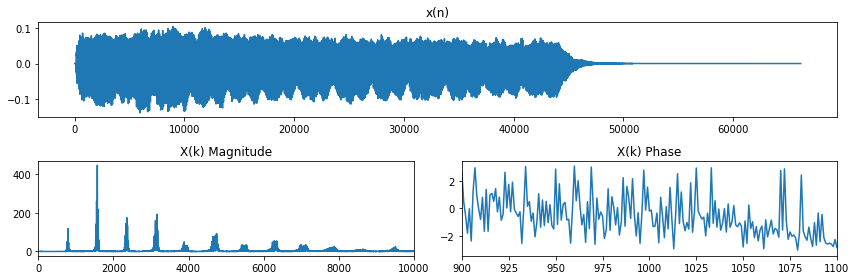

In [33]:
plt.figure(figsize=(12,4))
plt.subplot(2,1,1)
plt.plot(snd)
plt.title("x(n)")
plt.subplot(2,2,3)
plt.plot(np.abs(snd_ft))
plt.xlim(0,10000)
plt.title("X(k) Magnitude")
plt.subplot(2,2,4)
plt.plot(np.angle(snd_ft));
plt.xlim(900,1100)
plt.title("X(k) Phase")
plt.tight_layout()


Convert $X(k)$ back to $x(n)$ using `fft.irfft`

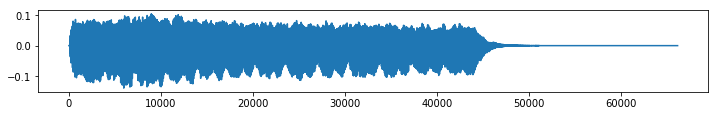

In [34]:
snd_rec = np.fft.irfft(snd_ft)
plt.figure(figsize=(12,1.5))
plt.plot(snd_rec);

It's fun to make changes to $X(k)$ before reconstruction:

In [35]:
@interact(a=(0.0, 1.0, 0.1))
def filter_snd(a=0.5):
    ymax = np.max(np.abs(snd_ft))
    L = len(snd_ft)
    filt = np.interp(np.arange(L), (0,L/10), (a, 1-a)) ** 3
    filt /= np.max(filt)
    mod_ft = snd_ft * filt
    snd_rec = np.fft.irfft(mod_ft)
    plt.subplot(1,3,1)
    plt.plot(np.abs(snd_ft))
    plt.ylim(0, ymax)
    plt.title("$X(k)$")
    plt.subplot(1,3,2)
    plt.plot(filt, 'r')
    plt.title("filter:$F(k)$")
    plt.ylim(0,1.3)
    plt.subplot(1,3,3)
    plt.plot(np.abs(mod_ft))
    plt.ylim(0, ymax)
    plt.title("$X(k) \cdot F(k)$")
    plt.show()
    return ipd.Audio(snd_rec, rate=fs)

interactive(children=(FloatSlider(value=0.5, description=u'a', max=1.0), Output()), _dom_classes=('widget-interact',))

### Inverse STFT

We have STFT, not just a DFT. We must reverse the STFT process.

The STFT of $x(n)$ involves:
- Windowing a signal by some window $w(n)$
- Taking the DFT
- Hopping by $H$

This results in the STFT, $\mathcal{X}(h,k)$ of the original signal $x(n)$.

For the ISTFT:
- At each hop $h_0$ of $\mathcal{X}(h,k)$, take the iDFT of $\mathcal{X}(h_0,k)$ to produce $x^w_h(n)$
- Sum all $x^w_h(n)$ with the correct time shifting to produce $\tilde x(n)$:
$$\tilde x(n) = \sum_h x^w_h(n - hH)$$
- in general $\tilde x(n) \ne x(n)$ because of windowing.
- We must undo the windowing process to recover $x(n)$ from $\tilde x(n)$.

Perfect reconstruction is clearly possible in the simple case of $H=N$ and a rectangular window $w(n)$:
$$
w(n) = 
\left\{
\begin{aligned} 
1,& \text{  if } n \in [0:N-1] \\
0,& \text{  otherwise} \\ 
\end{aligned} 
\right. 
$$

Example: Rectangular Window used in STFT.

In [36]:
x = load_wav("audio/violin_c4.wav")

@interact(hi=(0,3))
def test_recon(hi=0):
    fft_len = 4096
    hop_size = (4096, int(4096*1.5), int(4096/1.5), 4096/2)[hi]
    spec = fmp.stft(x, fft_len, hop_size, window=np.ones(fft_len))
    
    xr = fmp.istft(spec, hop_size, ignore_windowing=True)
    plt.figure(figsize=(12,5))
    plt.subplot(2,1,1)
    plt.plot(x)
    plt.ylim(-.3, .3)
    plt.title("original x(n)", fontsize=16)
    plt.subplot(2,1,2)
    plt.plot(xr)
    plt.ylim(-.3, .3)
    plt.title("reconstructed x(n) with N=%d H=%d" % (fft_len, hop_size), fontsize=16)
    plt.tight_layout()
    plt.show()
    return ipd.Audio(xr, rate=fs)

interactive(children=(IntSlider(value=0, description=u'hi', max=3), Output()), _dom_classes=('widget-interact',))

For a given window $w(n)$, where the sum of all shifted windows is:
$$ W(n) = \sum_h{w(n - hH)} $$

perfect reconstruction is possible if $W(n) \ne 0$ for all $n$.

To "undo" the effect of windowing present in $\tilde x(n)$, divide by $W(n)$:

$$x_r(n) = {\tilde x(n) \over W(n)}$$

A nice situation is when $W(n) = 1$.

This the case when:
- $w(n)$ is the Hann window (almost)
- $H = N/2$

In [39]:
from scipy.signal import triang

@interact(wt=(0,2), hop=(0,3))
def plot_windows(wt=0, hop=0):
    N = 512
    H = int(N * (1, 1.1, 0.75, 0.5)[hop])
    win = (np.ones(N), triang(N), np.hanning(N))[wt]
    hops = 5
    win_sum = np.zeros(N + (hops-1) * H)

    plt.figure(figsize=(12,4))
    plt.subplot(2,1,1)
    for n in range(hops):
        win_shift = np.zeros(len(win_sum))
        win_shift[n*H:n*H+N] += win
        win_sum += win_shift
        plt.plot(win_shift)
    plt.ylim(0, 2.1)
    plt.xlim(0, 3000)
    plt.title("windows N=%d, H=%d" % (N,H), fontsize=20)
    plt.subplot(2,1,2)
    plt.plot(win_sum)
    plt.ylim(0, 2.1);
    plt.xlim(0, 3000)
    plt.title("sum of windows: W(n)", fontsize=20)
    plt.tight_layout()
    plt.show()


interactive(children=(IntSlider(value=0, description=u'wt', max=2), IntSlider(value=0, description=u'hop', max=3), Output()), _dom_classes=('widget-interact',))

### Reconstruction Example

- Load audio
- Create STFT

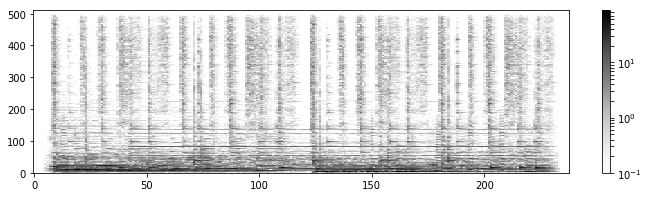

In [40]:
snd = load_wav("audio/latin_loop.wav")
stft = fmp.stft(snd, 1024, 512)
plot_spectrogram(np.abs(stft), cmap='Greys')
ipd.Audio(snd, rate = fs)

- Inverse STFT
- Play

In [41]:
snd_r = fmp.istft(stft, 512)
ipd.Audio(snd_r, rate = fs)

- Monkey around with STFT first
- Inverse STFT
- Play

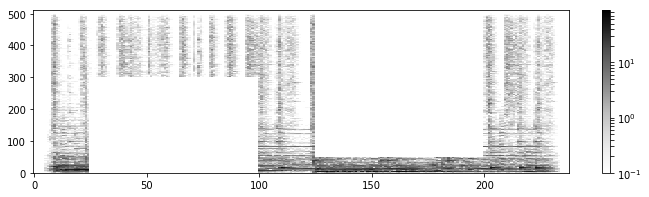

In [42]:
stft_mod = stft.copy()
stft_mod[0:300 ,  25:100] = 0
stft_mod[50:, 125:200] = 0
plot_spectrogram(np.abs(stft_mod), cmap='Greys')
snd_mod = fmp.istft(stft_mod, 512)
ipd.Audio(snd_mod, rate = fs)

## Harmonic / Percussive Separation

In [43]:
def spec_and_play(filepath):
    fs = 22050.
    snd = load_wav(filepath)
    spec = fmp.stft_mag(snd, 1024, 512)
    plot_spectrogram(spec[0:300,:], cmap='Greys')
    return ipd.Audio(snd, rate=fs)

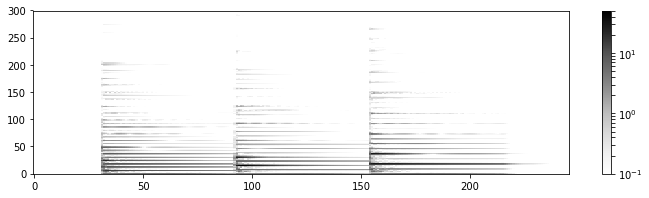

In [44]:
spec_and_play("audio/piano_CEG_octaves.wav")

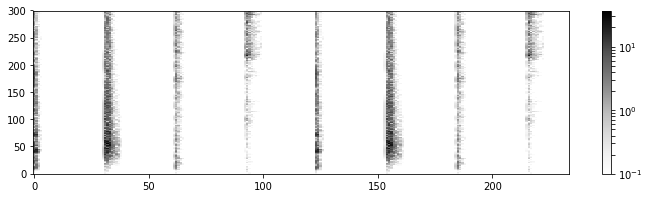

In [45]:
spec_and_play("audio/hits.wav")

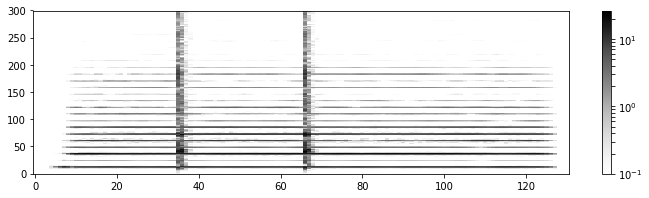

In [46]:
spec_and_play("audio/clarinet_hits.wav")

Observations:

- Horizontal lines
  - tonal or harmonic sound
  - modeled as steady sinusoids
  - narrow-band frequency range
  
  
- Vertical lines
  - percussive hits or sharp onsets
  - modeled as an impulse
  - wide-band frequency range
  
  
- Many sounds are one or the other or a combination
- Some sounds are neither (noise, applause)


### Goal

Separate a time-based signal $x$ into a harmonic component $x^h$ and a percussive component $x^p$ such that:
$$x = x^h + x^p$$

Strategy:
- Convert $x$ to the STFT: $\mathcal{X}(n,k)$
- Separate $\mathcal{X}(n,k)$ into two parts: $\mathcal{X}^h(n,k)$ and $\mathcal{X}^p(n,k)$ by:
  - Applying a harmonic filter to $\mathcal{X}(n,k)$ to create $\mathcal{X}^h(n,k)$
  - Applying a precussive filter to $\mathcal{X}(n,k)$ to create $\mathcal{X}^p(n,k)$ 
- Use the ISTFT to convert $\mathcal{X}^h(n,k)$ to $x^h$ and $\mathcal{X}^p(n,k)$ to $x^p$

### Identifying Outliers

Begin with the power spectrogram
$$\mathcal{Y}(n,k) = \vert \mathcal{X}(n,k) \vert ^2$$

Look at a single frequency $k_0$ across all $n$: a horizontal slice of $\mathcal{Y}(n,k)$ defined as $\mathcal{Y}^{k_0}(n) = \mathcal{Y}(n,k_0)$.  
A percussive event at some time $n_0$ is a spike in $\mathcal{Y}^{k_0}(n)$.

In [17]:
snd = load_wav("audio/clarinet_hits.wav")
fs = 22050.
stft = fmp.stft(snd, 1024, 512)
spec = np.abs(stft) ** 2

@interact(k=(46,51))
def plot_hslice(k=46):
    hline = spec[k,:]
    plt.figure(figsize=(12,6))
    plt.subplot(2,1,1)
    plot_spectrogram(spec[0:150,:], cmap='Greys', colorbar=False)
    plt.hlines(k, 0, 120, 'r')
    plt.subplot(2,1,2)
    plt.plot(hline)
    plt.xlim(0,len(hline))
    plt.ylim(0, 160)
    plt.title("slice at k=%d" % k)
    plt.show()

interactive(children=(IntSlider(value=46, description=u'k', max=51, min=46), Output()), _dom_classes=('widget-interact',))

Similarly, look at a single time $n_0$ across all $k$: a vertical slice of $\mathcal{Y}(n,k)$ defined as $\mathcal{Y}^{n_0}(k) = \mathcal{Y}(n_0,k)$.  
A harmonic event at some frequency $k_0$ is a spike in $\mathcal{Y}^{n_0}(k)$.

In [18]:
@interact(n=(28,38))
def plot_hslice(n=25):
    vline = spec[0:300, n]
    plt.figure(figsize=(12,6))
    plt.subplot(1,2,1)
    plot_spectrogram(spec[0:300,:], cmap='Greys', colorbar=False)
    plt.vlines(n, 0, 595, 'r')
    plt.subplot(1,2,2)
    plt.plot(vline, np.arange(len(vline)))
    plt.xlim(0, 250)
    plt.title("slice at n=%d" % n)
    plt.show()

interactive(children=(IntSlider(value=28, description=u'n', max=38, min=28), Output()), _dom_classes=('widget-interact',))

These spikes in the horizontal and vertial lines can be considered _outliers_.  
Outliers of a signal can be removed by __median filtering__.

### Median

The median of a list of numbers is the half-way point of that list sorted.

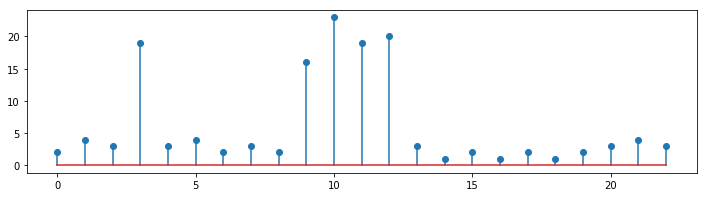

In [19]:
x = np.array((2,4,3,19,3,4,2,3,2,16,23,19,20,3,1,2,1,2,1,2,3,4,3,))
plt.stem(x);

Sort $x$ and pick mid-point

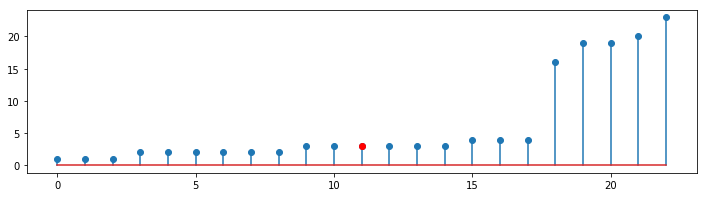

In [20]:
xs = np.sort(x)
plt.stem(xs);
mp = (len(xs)-1) / 2
plt.plot(mp, xs[mp], 'ro');

In [21]:
print 'Median:', np.median(x)
print 'Mean:', np.mean(x)

Median: 3.0
Mean: 6.17391304348


In [22]:
@interact(mm=False)
def show_mm(mm):
    plt.stem(x);
    m = np.mean(x) if mm else np.median(x)
    plt.title(("Median", "Mean")[mm])
    plt.hlines(m, 0, 25, 'r')
    plt.show()

interactive(children=(Checkbox(value=False, description=u'mm'), Output()), _dom_classes=('widget-interact',))

Note: if $\text{len}(x)$ is even, average the two midpoints.

### Median Filter

A _median filter_ applied to a signal $x(n)$ produces the signal $\tilde{x}(n)$ where $\tilde{x}(n_0)$ is the length $L$ median centered around $x(n_0)$.

- $L$ is usually odd.
- $x(n)$ is zero-padded by ${L-1 \over 2}$ on both sides to handle the edge cases.

In [23]:
from scipy.signal import medfilt

@interact(mm=False, L=(1,9,2))
def plot_filter(mm=False, L=1):
    xm = np.convolve(x, np.ones(L)/float(L), mode='same') if mm else medfilt(x, L)
    plt.figure(figsize=(12,5))
    plt.subplot(2,1,1)
    plt.stem(x)
    plt.subplot(2,1,2)
    plt.ylim(0, 25)
    plt.title(("Median", "Mean")[mm])
    plt.stem(xm)
    plt.show()

interactive(children=(Checkbox(value=False, description=u'mm'), IntSlider(value=1, description=u'L', max=9, min=1, step=2), Output()), _dom_classes=('widget-interact',))

Median Filters tend to:
- eleminate spikes
- enhance edges

### Creating Masks

We now apply median filtering to all rows of $\mathcal{Y}(n,k)$ to create 
$\tilde{\mathcal{Y}}^h(n,k)$

In [24]:
@interact(L=(1,15,2))
def plot_filter(L=1):
    spec_h = medfilt(spec, (1, L))
    plot_spectrogram(spec_h[0:300], cmap='Greys', colorbar=False)
    plt.title("Harmonic Median Filtered Spectrogram with L=%d" % L)
    plt.show()

interactive(children=(IntSlider(value=1, description=u'L', max=15, min=1, step=2), Output()), _dom_classes=('widget-interact',))

And to the columns of $\mathcal{Y}(n,k)$ to create 
$\tilde{\mathcal{Y}}^p(n,k)$

In [ ]:
@interact(L=(1,21,2))
def plot_filter(L=1):
    spec_p = medfilt(spec, (L, 1))
    plot_spectrogram(spec_p[0:300], cmap='Greys', colorbar=False)
    plt.title("Percussive Median Filtered Spectrogram with L=%d" % L)
    plt.show()

We are not done yet!

Instead of using these filtered Spectrograms directly, we use them to create Masks that can operate on the original STFT:

These are __binary masks__. They "assign" a STFT cell to be either harmonic or percussive:

$$
\mathcal{M}^h(n,k) = 
\left\{
\begin{aligned} 
1,& \text{  if } \tilde{\mathcal{Y}}^h(n,k) \ge \tilde{\mathcal{Y}}^p(n,k) \\ 
0,& \text{  otherwise} \\ 
\end{aligned} 
\right. 
$$

$$
\mathcal{M}^p(n,k) = 
\left\{
\begin{aligned} 
1,& \text{  if } \tilde{\mathcal{Y}}^h(n,k) \lt \tilde{\mathcal{Y}}^p(n,k) \\ 
0,& \text{  otherwise} \\ 
\end{aligned} 
\right. 
$$


Here is what they look like

In [ ]:
spec_h = medfilt(spec, (1, 13))
spec_p = medfilt(spec, (21, 1))

bmask_h = spec_h >= spec_p
bmask_p = np.logical_not(bmask_h)

plt.subplot(1,2,1)
plot_spectrogram(bmask_h[0:300,:], cmap='Greys', colorbar=False)
plt.title("harmonic mask")
plt.subplot(1,2,2)
plt.title("percussive mask")
plot_spectrogram(bmask_p[0:300,:], cmap='Greys', colorbar=False)

We apply these masks onto the original STFT $\mathcal{X}$(n,k) by doing a point-by-point multiplication:

$$\mathcal{X}^h(n,k) = \mathcal{M}^h(n,k) \cdot \mathcal{X}(n,k)$$
$$\mathcal{X}^p(n,k) = \mathcal{M}^p(n,k) \cdot \mathcal{X}(n,k)$$

Remember that $\mathcal{X}(n,k)$ is complex-valued, and so are $\mathcal{X}^h(n,k)$ and $\mathcal{X}^p(n,k)$.

Results of applying masks:

In [ ]:
spec_h = bmask_h * spec
spec_p = bmask_p * spec

plt.subplot(1,2,1)
plot_spectrogram(spec_h[0:300,:], cmap='Greys', colorbar=False)
plt.title("harmonic spectrogram")
plt.subplot(1,2,2)
plt.title("percussive spectrogram")
plot_spectrogram(spec_p[0:300,:], cmap='Greys', colorbar=False)

While binary masks work fine, it is often better to have "softer edges" to our masking filters. These are __soft masks__, also known as __Wiener filtering__:

$$ \mathcal{M}^h(n,k) = {  \tilde{\mathcal{Y}}^h(n,k) + {\epsilon \over 2} \over \tilde{\mathcal{Y}}^h(n,k) + \tilde{\mathcal{Y}}^p(n,k) + \epsilon }$$

$$ \mathcal{M}^p(n,k) = {  \tilde{\mathcal{Y}}^p(n,k) + {\epsilon \over 2} \over \tilde{\mathcal{Y}}^h(n,k) + \tilde{\mathcal{Y}}^p(n,k) + \epsilon }$$

They look like this:

In [ ]:
eps = 0.0001
denom = (spec_h + spec_p + eps)
smask_h = (spec_h + eps/2) / denom
smask_p = (spec_p + eps/2) / denom

plt.subplot(1,2,1)
plot_spectrogram(smask_h[0:300,:], cmap='Greys', colorbar=False)
plt.title("harmonic mask")
plt.subplot(1,2,2)
plt.title("percussive mask")
plot_spectrogram(smask_p[0:300,:], cmap='Greys', colorbar=False)

It makes a small difference here, but a bigger difference with more complex music.

### Reconstruction

The final step is to convert $\mathcal{X}^h(n,k)$ and $\mathcal{X}^p(n,k)$ back into the time domain.

Apply soft masks to STFT

In [ ]:
stft_h = smask_h * stft
stft_p = smask_p * stft

plt.subplot(1,2,1)
plot_spectrogram(np.abs(stft_h[0:300,:]), cmap='Greys', colorbar=False)
plt.title("harmonic spectrogram")
plt.subplot(1,2,2)
plt.title("percussive spectrogram")
plot_spectrogram(np.abs(stft_p[0:300,:]), cmap='Greys', colorbar=False)

In [ ]:
snd_h = fmp.istft(stft_h, 512)
ipd.Audio(snd_h, rate = fs)

In [ ]:
snd_p = fmp.istft(stft_p, 512)
ipd.Audio(snd_p, rate = fs)

Another example:

In [ ]:
snd = load_wav("audio/latin_loop.wav")
ipd.Audio(snd, rate = fs)

Apply HPSS:

In [ ]:
snd_h, snd_p = fmp.hps(snd, h_filt_len=13, p_filt_len=21)

Harmonic Signal:

In [ ]:
ipd.Audio(snd_h, rate = fs)

Percussive Signal:

In [ ]:
ipd.Audio(snd_p, rate = fs)

### Applications

- Isolating drum hits as a precursor to percussion identification tasks
- Pre-processing step for other MIR methods:

<img src="images/chroma_and_onsets.png" width=800>

## Non-Negatie Matrix Factorization

__Goal__: to decompose music into notewise audio events

<img src="images/score_decomp.png" width=400>

To illustrate, start with a Spectrogram-like Matrix $V$, a $K \times N$ matrix (in this example, $K = 11$ and $N = 7$).

<img src="images/NMF_toy1.png" width=250>

$V$ can be _factored_ into the product of two smaller matrices:
- $W$, a $K \times R$ matrix - the __templates__ matrix.
- $H$, a $R \times N$ matrix - the __activations__ matrix.
- Here, $R = 3$

<img src="images/NMF_toy2.png" width=400>

$$V = W \cdot H$$

- NMF is a factorization where all cells in $W$, $H$ (and of coruse $V$) are non-negative.
- Goal: to find $W$ and $H$ such that $V \approx W H$.
- $R$ is the __rank__ of the factorization. Should be relatively small.
- Want $H$ and $W$ to "mean something" useful.

### Factorization by Gradient Descent

For the gory details, see text, pages 454-459.

Optimization problem: find $W$ and $H$ so as to minimize the Euclidean distance:
$$\phi = {\Vert V - W H \Vert}$$

Gradient Descent is an iterative process:  
- Initialize $W$ and $H$ somehow (either random values or some other way)
- Make small changes to $W$ and $H$, thereby moving towards a local minimum in the distance metric.
- Stop when $\phi$ stops changing by very much.
- NMF factorization has a special property that keeps all values of $W$ and $H$ positive.

The update step for modifying $W$ and $H$ are:
$$H = H \odot W^\top V \oslash (W^\top W H)$$
$$W = W \odot V H^\top  \oslash (W H H^\top)$$

Note: $\odot$ and $\oslash$ are symbols for _elementwise_ multiplication and division.

#### Example
First 4 bars of Mozart's _Piano Sonata in C_.  
Create $\mathcal{X}(n,k)$, the STFT of $x(n)$, with $N=2048$, $H=1024$.

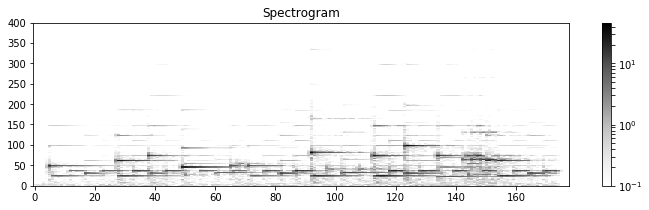

In [6]:
snd = load_wav("audio/mozart_sonata_c.wav")
fs = 22050.

fft_len = 2048
hop_size = fft_len / 2
stft = fmp.stft(snd, fft_len, hop_size)
plot_spectrogram(np.abs(stft[0:400,:]), cmap='Greys')
plt.title("Spectrogram")
ipd.Audio(snd, rate=fs)

Score:
<img src="images/mozart_sonata_c.png" width=600>

To run NMF:
- $V = \vert \mathcal{X}(n,k)\vert$
- initialize $H$ and $W$ to be random values
- choose $R = 15$ (why 15?)

In [7]:
V = np.abs(stft)

K, N = V.shape
R = 15
print "K=%d\nN=%d\nR=%d" % (K, N, R)

Wi = np.random.random((K,R))
Hi = np.random.random((R, N))



K=1025
N=178
R=15


Run gradient decent:

In [8]:
stages = fmp.nmf_descent_stages(V, Wi, Hi)

@interact(s=(0, len(stages)-1))
def show_stage(s=0):
    i,W,H,err = stages[s]
    plt.subplot(1,2,1)
    plot_spectrogram(W[0:500,:], cmap='Greys', colorbar=False)
    plt.title('W', fontsize=15)
    plt.subplot(1,2,2)
    plt.imshow(H, origin='lower', aspect='auto', cmap='Greys', vmax=.2)
    plt.title('H', fontsize=15)
    plt.text(-100, 16, 'iteration= %d. ||V - WH|| = %.2f' % (i, err), fontsize=15)
    plt.show()
    

interactive(children=(IntSlider(value=0, description=u's', max=43), Output()), _dom_classes=('widget-interact',))

This looks interesting. $H$ and $W$ have some structure. But we want something better.


Initialize $W$ to be a more meaningful template:
- One column per piano note found in the score. 
- Look at the sheet music to get the pitches.

They are:

In [9]:
mozart_pitches = (59, 60, 62, 64, 65, 67, 69, 71, 72, 74, 76, 77, 79, 81, 84)

Construct $W$ with a harmonic model of these 15 pitches:

(1025, 15)


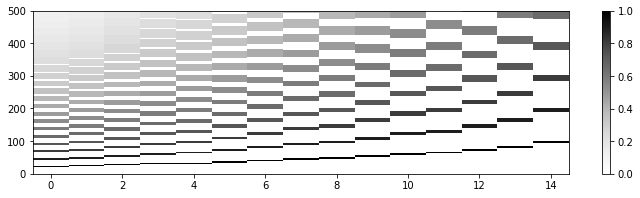

In [12]:
Wi = fmp.build_W(fs, fft_len, mozart_pitches)
print Wi.shape
plt.imshow(Wi[0:500,:], origin='lower', aspect='auto', cmap='Greys')
plt.colorbar();

In [11]:
stages = fmp.nmf_descent_stages(V, Wi, Hi)
@interact(s=(0, len(stages)-1))
def show_stage(s=0):
    i,W,H,err = stages[s]
    plt.subplot(1,2,1)
    plot_spectrogram(W[0:500,:], cmap='Greys')
    plt.title('W', fontsize=15)
    plt.subplot(1,2,2)
    plt.imshow(H, origin='lower', aspect='auto', cmap='Greys', vmax=0.2)
    plt.title('H', fontsize=15)
    plt.text(-100, 16, 'iteration= %d. |V - WH| = %.2f' % (i, err), fontsize=15)
    plt.show()

interactive(children=(IntSlider(value=0, description=u's', max=43), Output()), _dom_classes=('widget-interact',))

Now $H$ looks much more like sheet music (or MIDI representation).

### Analysis of $H$ (activations)

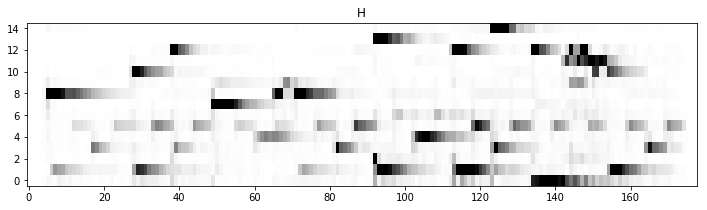

In [13]:
Hi = np.ones((R, N))
Wo, Ho = fmp.nmf(V, Wi, Hi)
plt.imshow(Ho, origin='lower', aspect='auto', cmap='Greys', vmax=0.2)
plt.title('H');

Let's look at each activation row:

In [14]:
H_smooth = fmp.temporal_smoothing(Ho, 7, 'hann', False)
@interact(p=(0,Ho.shape[0]-1), smoo=False)
def plot_activation(p=0, smoo=False):
    plt.plot(H_smooth[p,:] if smoo else Ho[p,:])
    plt.ylim(0, 0.5)
    plt.title("activation for pitch=%d" % mozart_pitches[p], fontsize=15)
    plt.show()

interactive(children=(IntSlider(value=0, description=u'p', max=14), Checkbox(value=False, description=u'smoo'), Output()), _dom_classes=('widget-interact',))

Use peak picking to locate pitches in time and synthesize:

In [15]:
def pick_notes(H, pitches):
    notes = []
    for i in range(H.shape[0]):
        h = H[i,:]
        times = fmp.find_peaks2(h, 5, .1)
        times = times[ h[times] > .02 ]
        notes += [(t, pitches[i]) for t in times]
    notes.sort()
    return notes

notes = pick_notes(H_smooth, mozart_pitches)
ff = fs/hop_size
mel = fmp.synthesize_sequence(notes, fs, hop_size)
ipd.Audio(mel, rate=fs)

### Analaysis of $W \cdot H$

We can recreate an approximation of the original Spectrogram with:
$$V' = W \cdot H$$

In [ ]:
Vo = np.dot(Wo, Ho);

@interact(approx=False)
def compare_specs(approx):
    X = Vo if approx else V
    txt = "V' = WH" if approx else 'original spec'
    plot_spectrogram(X[0:400,:], cmap='Greys')
    plt.title(txt, fontsize=15)
    plt.show()

Note data compression: $W \cdot H$ takes $10 \times$ less memory.

In [ ]:
print "Spec size = %d x %d = %d" % (K, N, K*N)
print "W + H size = %d x %d + %d x %d = %d" % (K, R, R, N, K*R + R*N)

Let's listen to $W \cdot H$ by creating $x_r$ with iSTFT:

In [ ]:
x_r = fmp.istft(Vo, hop_size)
ipd.Audio(x_r, rate=fs)

What happened? Why does this sound bad?

Remember that $V'$ has only real values, whereas the STFT $\mathcal{X}(n,k)$ is a complex matrix.  
$V'$ alone has no phase information!  
We can "transfer" the phase information from $\mathcal{X}(n,k)$ to $V'$

In [ ]:
spec_r = fmp.transfer_phase(Vo, stft)
x_r = fmp.istft(spec_r, hop_size)
ipd.Audio(x_r, rate=fs)


### NMF-based Source Separation

We can do a lot more with $H$. For example, we can separate the left and right hands of the piano recording.

Here is $H$ again:

In [ ]:
plt.imshow(Ho, origin='lower', aspect='auto', cmap='Greys', vmax=0.2)
plt.title('H');

Left hand pitches are in $H$ with rows $h \in [0,6] \rightarrow H^L$.  
Right hand pitches are in $H$ with rows $h \in [7,14] \rightarrow H^R$.

In [ ]:
## left / right split:
H_left = Ho.copy()
H_left[7:,:] = 0
H_right = Ho.copy()
H_right[0:7,:] = 0

plt.subplot(1,2,1)
plt.imshow(H_left, origin='lower', aspect='auto', cmap='Greys', vmax=0.3)
plt.title("H Left Hand")
plt.subplot(1,2,2)
plt.imshow(H_right, origin='lower', aspect='auto', cmap='Greys', vmax=0.3)
plt.title("H Right Hand");

Reconstruct a Left Hand and Right Hand Spectrogram:
- $V^L = W \cdot H^L $
- $V^R = W \cdot H^R $
- Transfer phase information from $\mathcal{X}(n,k)$

In [ ]:
spec_l = fmp.transfer_phase(np.dot(Wo, H_left), stft)
spec_r = fmp.transfer_phase(np.dot(Wo, H_right), stft)

plt.subplot(1,2,1)
plot_spectrogram(np.abs(spec_l[0:400,:]), cmap='Greys')
plt.title("$V^L$", fontsize=15)
plt.subplot(1,2,2)
plot_spectrogram(np.abs(spec_r[0:400,:]), cmap='Greys')
plt.title("$V^R$", fontsize=15);

In [ ]:
# play reconstructed left / right
x_left = fmp.istft(spec_l, hop_size)
x_right = fmp.istft(spec_r, hop_size)
ipd.Audio(x_left, rate = fs)

In [ ]:
ipd.Audio(x_right, rate = fs)

An alternative: create soft masks from $H^L$ and $H^R$ instead of using them directly:

$$M^L = (WH^L) \oslash (WH + \epsilon)$$
$$M^R = (WH^R) \oslash (WH + \epsilon) $$

In [ ]:
# create masked reconstructions
x_left  = fmp.mask_and_reconstruct(Wo, Ho, H_left, stft, hop_size)
x_right = fmp.mask_and_reconstruct(Wo, Ho, H_right, stft, hop_size)

ipd.Audio(x_left, rate=fs)

In [ ]:
ipd.Audio(x_right, rate=fs)

This is just an introduction to NMF. Many variations exist that do a better job. For example:
- score informed NMF to initialize $H$ with rough locations of notes
<img src="images/initialized_H.png" width=500>

- add accommodation for percussive transients for each piano note in $W$ and $H$.
<img src="images/NMF_with_transients.png" width=500>